# JAX features

This notebook demonstrates the jax features of spotter, which greatly accelerate the computation of light curves and their amplitudes.

## The JAX methods
Let's create a star and add two spots

In [1]:
from spotter import Star
import numpy as np

star = Star(N=2**5)
u = [0.3, 0.2]
star.add_spot(np.pi / 3, np.pi / 4, 0.1, 0.2)
star.add_spot(np.pi / 2, np.pi / 5, 0.3, 0.1)
star.show()

TypeError: __init__() got an unexpected keyword argument 'u'

Using JAX, we can compile the computation of the light curve

In [ ]:
phase = np.linspace(0, 2 * np.pi, 200)
flux = star.jax_flux(phase)

where `flux` will be a function of the *healpix* pixels values, such as

In [ ]:
flux(star.map_spot)

Array([0.85906195, 0.85883927, 0.85859914, 0.85839573, 0.85818691,
       0.85797618, 0.8577933 , 0.85763151, 0.85744773, 0.8572905 ,
       0.85715632, 0.85702478, 0.85689694, 0.85679329, 0.85671556,
       0.85661782, 0.85654607, 0.85650284, 0.85645886, 0.85642002,
       0.85640841, 0.85642173, 0.85641617, 0.85643822, 0.85648749,
       0.8565423 , 0.85659001, 0.85667064, 0.85677558, 0.85686195,
       0.85697405, 0.85711258, 0.85724927, 0.85739002, 0.8575587 ,
       0.8577468 , 0.85791599, 0.85810815, 0.85832604, 0.85853825,
       0.85875297, 0.85899186, 0.85924656, 0.85947874, 0.85973493,
       0.86000789, 0.8602715 , 0.86053988, 0.86081819, 0.86111302,
       0.86136225, 0.86167415, 0.86196828, 0.86225298, 0.86253529,
       0.8628254 , 0.86312485, 0.86339261, 0.86366905, 0.86395605,
       0.8642201 , 0.86447275, 0.86473103, 0.86498203, 0.86519002,
       0.86539886, 0.86560534, 0.86577535, 0.86592854, 0.86607966,
       0.86622021, 0.86631755, 0.86641409, 0.86650791, 0.86656

This way, the fluxes of a large number of maps can be computed more efficiently. Let's benchmark the standard implementation against the jax implementation:

In [ ]:
# standard
%timeit star.flux(phase)

177 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# jax
# note here the change of argument

import jax
%timeit jax.block_until_ready(flux(star.map_spot))

2.86 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In this case, we note a huge 
speedup. For convenience, we define the `jax_amplitude` method that computes the peak to peak amplitude of the variability with a resolution being relative to that of the map (accessible as `star.resolution`), i.e.

In [ ]:
# resolution is 2 times that of a pixel element
amplitude = star.jax_amplitude(resolution=2)

amplitude(star.map_spot)

Array(0.01026046, dtype=float64)

## Non-useful case study

As a case study, let try to derive the relation between number of spots and amplitude for a stellar surface covered by spots with fixed radii amd contrast, and given a certain spot distribution.

Here is an example of such star:

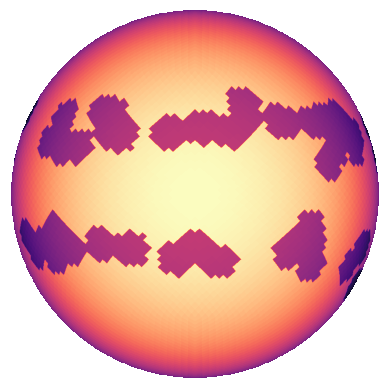

In [3]:
import numpy as np
from spotter import Star, butterfly

star = Star(N=2**5)
u = [0.3, 0.2]

angles = butterfly(np.deg2rad(20), np.deg2rad(5), 100)
x = 1 - star.circular_spots(True)(*angles, 0.1)[-1] * 0.3
star.show(x, u)

We can run this random draw of spots 500 times and record the amplitude variation, all relatively efficiently using the JAX methods

In [9]:
import jax
from tqdm import tqdm

draws = 500
max_spots = 500

amplitudes = np.zeros((draws, max_spots))
amplitude_function = jax.jit(star.amplitude(u, resolution=5))

for i in tqdm(range(draws)):
    angles = butterfly(np.deg2rad(20), np.deg2rad(5), max_spots)
    maps = 1 - star.circular_spots(accumulate=True, jit=False)(*angles, 0.1) * 0.2
    amplitudes[i, :] = amplitude_function(maps)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:09<00:00, 51.77it/s]


Let see the result

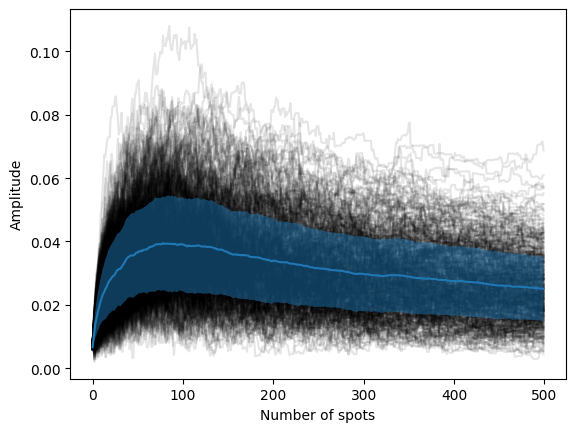

In [10]:
import matplotlib.pyplot as plt

mean, std = np.mean(amplitudes, axis=0), np.std(amplitudes, axis=0)

for i in range(draws):
    plt.plot(amplitudes[i, :], c="k", alpha=0.1, zorder=0)

plt.fill_between(np.arange(max_spots), mean - std, mean + std, alpha=0.5, zorder=1)
plt.plot(mean, zorder=2)
plt.xlabel("Number of spots")
_ = plt.ylabel("Amplitude")

That's it, not sure how useful but that demonstrates the kind of statistics that can be done as an ensemble.

The thing to note here is the trade-offs involved in the resolution of the phase grid used to compute the amplitude, and the resolution of the healpix map itself.